In [ ]:
# Note: You can select between running the Notebook on "CPU" or "GPU"
# Click "Runtime > Change Runtime time" and set "GPU"

In [ ]:
#Uncomment to install synthetic lib
#! pip install synthetic

# Time Series synthetic data generation with TimeGAN

- TimeGAN - Implemented accordingly with the [paper](https://papers.nips.cc/paper/8789-time-series-generative-adversarial-networks)
- This notebook is an example of how TimeGan can be used to generate synthetic time-series data.

## Dataset and imports

- The data used in this notebook was downloaded from [Yahoo finance](https://finance.yahoo.com/quote/GOOG/history?p=GOOG) and includes:
    - **6 variables** - Open, High, Low, Close, Adj Close, Volume
    - **1022 events** registered between the period of 1 January 2017 - 24 January 2021.
    - The data was processed using a MinMaxScaler (all the variables were numeric)

In [1]:
#Importing the required libs for the exercise

from os import path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pysynthetic.preprocessing.timeseries import processed_stock
from pysynthetic.synthesizers.timeseries import TimeGAN

## Define Model hyperparameters

**Networks:**
- Generator
- Discriminator
- Embedder
- Recovery Network

TimeGAN is a Generative model based on RNN networks. In this package the implemented version follows a very simple architecture that is shared by the four elements of the GAN.

Similarly to other parameters, the architectures of each element should be optimized and tailored to the data.

In [2]:
#Specific to TimeGANs
seq_len=24
n_seq = 6
hidden_dim=24
gamma=1

noise_dim = 32
dim = 128
batch_size = 128

log_step = 100
learning_rate = 5e-4

gan_args = [batch_size, learning_rate, noise_dim, 24, 2, (0, 1), dim]

## The data

In [3]:
stock_data = processed_stock(seq_len=seq_len)
print(len(stock_data),stock_data[0].shape)

997 (24, 6)


In [10]:
stock_data[0:3] , stock_data[0].shape

([array([[0.3306409 , 0.31765675, 0.33085727, 0.32838524, 0.32838524,
          0.30301014],
         [0.32616444, 0.31944672, 0.32829726, 0.32825965, 0.32825965,
          0.17006246],
         [0.32372519, 0.31161426, 0.32176442, 0.31271584, 0.31271584,
          0.19787721],
         [0.31474544, 0.30575521, 0.31938433, 0.31677886, 0.31677886,
          0.09644722],
         [0.30360348, 0.30354602, 0.30846477, 0.30841051, 0.30841051,
          0.12499573],
         [0.30322828, 0.294299  , 0.30266086, 0.30023048, 0.30023048,
          0.16108665],
         [0.31496881, 0.30228858, 0.30659315, 0.30291231, 0.30291231,
          0.20019795],
         [0.32466341, 0.30855811, 0.31489238, 0.3145904 , 0.3145904 ,
          0.23060646],
         [0.32360903, 0.31094893, 0.32159339, 0.3170839 , 0.3170839 ,
          0.22715948],
         [0.30693623, 0.30758888, 0.31152875, 0.31675204, 0.31675204,
          0.26326747],
         [0.28640354, 0.2884748 , 0.29037803, 0.29900169, 0.29900169,


## Training the TimeGAN synthetizer

In [11]:
if path.exists('synthesizer_stock.pkl'):
    synth = TimeGAN.load('synthesizer_stock.pkl')
else:
    synth = TimeGAN(model_parameters=gan_args, hidden_dim=24, seq_len=seq_len, n_seq=n_seq, gamma=1)
    synth.train(stock_data, train_steps=50000)
    synth.save('synthesizer_stock.pkl')

Joint networks training: 100%|███████████████████████████████████████████████████████| 500/500 [07:06<00:00,  1.17it/s]


### The generated synthetic stock data

In [12]:
synth_data = synth.sample(len(stock_data))
print(synth_data.shape)

Synthetic data generation: 100%|█████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.55it/s]

(1024, 24, 6)


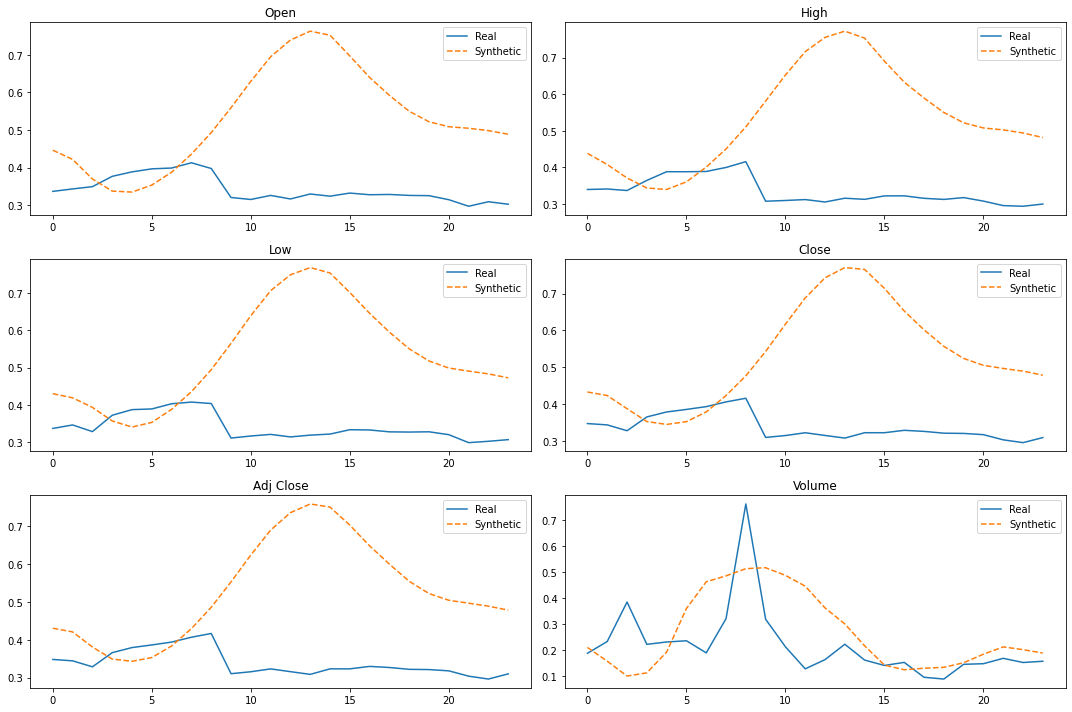

In [13]:
#Reshaping the data
cols = ['Open','High','Low','Close','Adj Close','Volume']

#Plotting some generated samples. Both Synthetic and Original data are still standartized with values between [0,1]
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
axes=axes.flatten()

time = list(range(1,25))
obs = np.random.randint(len(stock_data))

for j, col in enumerate(cols):
    df = pd.DataFrame({'Real': stock_data[obs][:, j],
                   'Synthetic': synth_data[obs][:, j]})
    df.plot(ax=axes[j],
            title = col,
            secondary_y='Synthetic data', style=['-', '--'])
fig.tight_layout()

#### Evaluation of the generated synthetic data (PCA and TSNE)

In [14]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
idx = np.random.permutation(len(stock_data))[:sample_size]

real_sample = np.asarray(stock_data)[idx]
synthetic_sample = np.asarray(synth_data)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

Text(0.5, 0.98, 'Validating synthetic vs real data diversity and distributions')

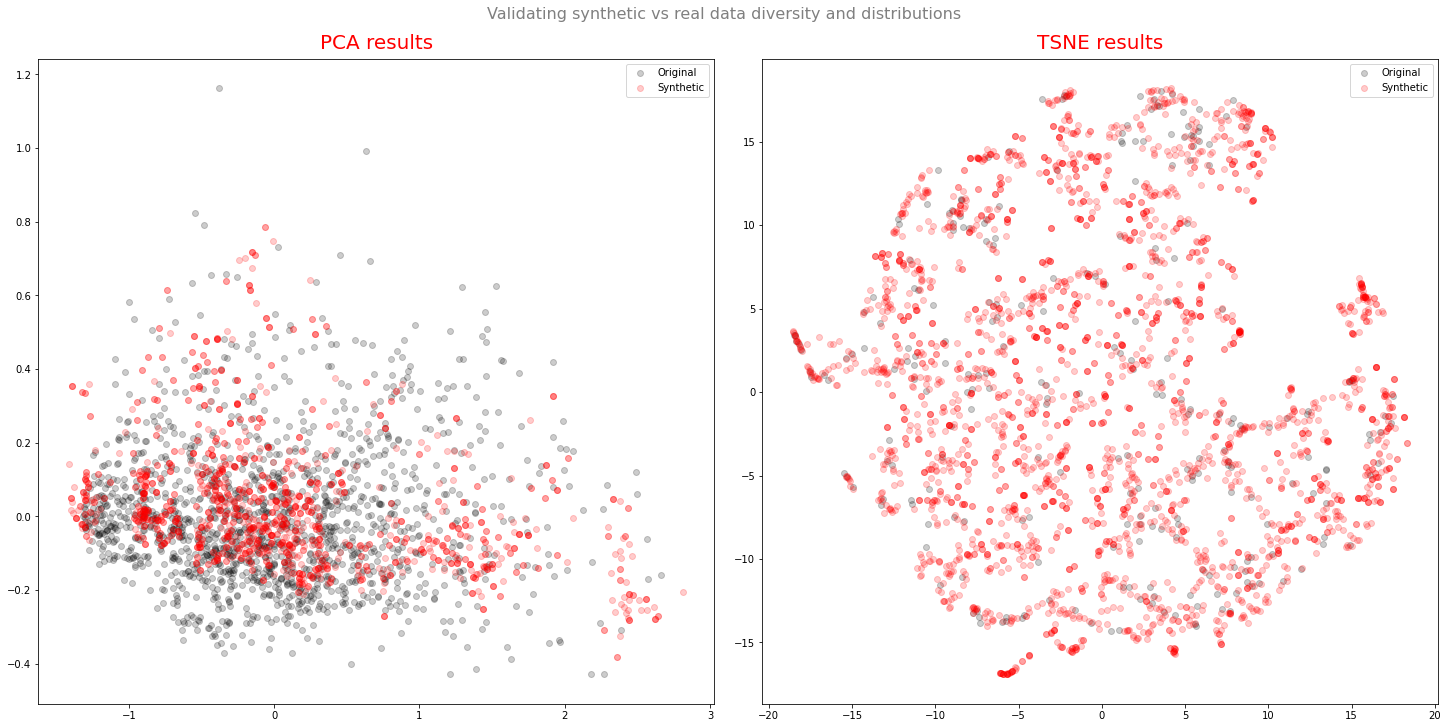

In [15]:
#The scatter plots for PCA and TSNE methods
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')

#### Train synthetic test real (TSTR)

In [16]:
from tensorflow.keras import Input, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError

#First implement a simple RNN model for prediction
def RNN_regression(units):
    opt = Adam(name='AdamOpt')
    loss = MeanAbsoluteError(name='MAE')
    model = Sequential()
    model.add(GRU(units=units,
                  name=f'RNN_1'))
    model.add(Dense(units=6,
                    activation='sigmoid',
                    name='OUT'))
    model.compile(optimizer=opt, loss=loss)
    return model

In [17]:
#Prepare the dataset for the regression model
stock_data=np.asarray(stock_data)
synth_data = synth_data[:len(stock_data)]
n_events = len(stock_data)

#Split data on train and test
idx = np.arange(n_events)
n_train = int(.75*n_events)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

#Define the X for synthetic and real data
X_stock_train = stock_data[train_idx, :seq_len-1, :]
X_synth_train = synth_data[train_idx, :seq_len-1, :]

X_stock_test = stock_data[test_idx, :seq_len-1, :]
y_stock_test = stock_data[test_idx, -1, :]

#Define the y for synthetic and real datasets
y_stock_train = stock_data[train_idx, -1, :]
y_synth_train = synth_data[train_idx, -1, :]

print('Synthetic X train: {}'.format(X_synth_train.shape))
print('Real X train: {}'.format(X_stock_train.shape))

print('Synthetic y train: {}'.format(y_synth_train.shape))
print('Real y train: {}'.format(y_stock_train.shape))

print('Real X test: {}'.format(X_stock_test.shape))
print('Real y test: {}'.format(y_stock_test.shape))

Synthetic X train: (747, 23, 6)
Real X train: (747, 23, 6)
Synthetic y train: (747, 6)
Real y train: (747, 6)
Real X test: (250, 23, 6)
Real y test: (250, 6)


In [18]:
#Training the model with the real train data
ts_real = RNN_regression(12)
early_stopping = EarlyStopping(monitor='val_loss')

real_train = ts_real.fit(x=X_stock_train,
                          y=y_stock_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
6/6 [==============================] - 1s 62ms/step - loss: 0.2278 - val_loss: 0.2303
Epoch 2/200
6/6 [==============================] - 0s 12ms/step - loss: 0.2216 - val_loss: 0.2243
Epoch 3/200
6/6 [==============================] - 0s 11ms/step - loss: 0.2177 - val_loss: 0.2181
Epoch 4/200
6/6 [==============================] - 0s 13ms/step - loss: 0.2115 - val_loss: 0.2116
Epoch 5/200
6/6 [==============================] - 0s 11ms/step - loss: 0.2069 - val_loss: 0.2049
Epoch 6/200
6/6 [==============================] - 0s 11ms/step - loss: 0.2001 - val_loss: 0.1979
Epoch 7/200
6/6 [==============================] - 0s 11ms/step - loss: 0.1897 - val_loss: 0.1907
Epoch 8/200
6/6 [==============================] - 0s 14ms/step - loss: 0.1824 - val_loss: 0.1835
Epoch 9/200
6/6 [==============================] - 0s 13ms/step - loss: 0.1756 - val_loss: 0.1764
Epoch 10/200
6/6 [==============================] - 0s 11ms/step - loss: 0.1726 - val_loss: 0.1694
Epoch 11/200
6/6 [=

In [19]:
#Training the model with the synthetic data
ts_synth = RNN_regression(12)
synth_train = ts_synth.fit(x=X_synth_train,
                          y=y_synth_train,
                          validation_data=(X_stock_test, y_stock_test),
                          epochs=200,
                          batch_size=128,
                          callbacks=[early_stopping])

Epoch 1/200
6/6 [==============================] - 1s 49ms/step - loss: 0.2299 - val_loss: 0.2267
Epoch 2/200
6/6 [==============================] - 0s 12ms/step - loss: 0.2230 - val_loss: 0.2221
Epoch 3/200
6/6 [==============================] - 0s 12ms/step - loss: 0.2195 - val_loss: 0.2177
Epoch 4/200
6/6 [==============================] - 0s 12ms/step - loss: 0.2149 - val_loss: 0.2131
Epoch 5/200
6/6 [==============================] - 0s 11ms/step - loss: 0.2074 - val_loss: 0.2079
Epoch 6/200
6/6 [==============================] - 0s 11ms/step - loss: 0.2021 - val_loss: 0.2020
Epoch 7/200
6/6 [==============================] - 0s 11ms/step - loss: 0.2012 - val_loss: 0.1954
Epoch 8/200
6/6 [==============================] - 0s 12ms/step - loss: 0.1919 - val_loss: 0.1880
Epoch 9/200
6/6 [==============================] - 0s 12ms/step - loss: 0.1773 - val_loss: 0.1803
Epoch 10/200
6/6 [==============================] - 0s 11ms/step - loss: 0.1710 - val_loss: 0.1724
Epoch 11/200
6/6 [=

In [20]:
#Summarize the metrics here as a pandas dataframe
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_log_error
real_predictions = ts_real.predict(X_stock_test)
synth_predictions = ts_synth.predict(X_stock_test)

metrics_dict = {'r2': [r2_score(y_stock_test, real_predictions),
                       r2_score(y_stock_test, synth_predictions)],
                'MAE': [mean_absolute_error(y_stock_test, real_predictions),
                        mean_absolute_error(y_stock_test, synth_predictions)],
                'MRLE': [mean_squared_log_error(y_stock_test, real_predictions),
                         mean_squared_log_error(y_stock_test, synth_predictions)]}

results = pd.DataFrame(metrics_dict, index=['Real', 'Synthetic'])

results

,r2,MAE,MRLE
Real,0.810066,0.032352,0.002134
Synthetic,0.767277,0.039786,0.002699
